# Install dependencies


In [61]:
%pip install torch gensim datasets nltk


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Import dependencies


In [62]:
import os
import json
import nltk
nltk.download("all")


import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from datasets import load_dataset
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader
from gensim.downloader import load as load_word2vec

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/harry.tran/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/harry.tran/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/harry.tran/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/harry.tran/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/harry.tran/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is alread

# Part 0. Dataset Preparation


In [63]:
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset["train"]
validation_dataset = dataset["validation"]
test_dataset = dataset["test"]

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Simple statatistics about dataset


In [65]:
print(f"Size of training set: {train_dataset.num_rows} sentences")
print(f"Size of validation set: {validation_dataset.num_rows} sentences")
print(f"Size of test set: {test_dataset.num_rows} sentences")

Size of training set: 8530 sentences
Size of validation set: 1066 sentences
Size of test set: 1066 sentences


In [66]:
print(f"Sample sentence from train dataset: {test_dataset[0]['text']}")
print(f"Label: {'Positive' if test_dataset[0]['label'] == 1 else 'Negative'}")

Sample sentence from train dataset: lovingly photographed in the manner of a golden book sprung to life , stuart little 2 manages sweetness largely without stickiness .
Label: Positive


# Part 1. Preparing Word Embeddings


## Question 1. Word Embedding


#### `(a)` What is the size of the vocabulary formed from your training data?


In [67]:
# Tokenize each sentence
tokenized_texts = [word_tokenize(text["text"].lower()) for text in train_dataset]
print(f"Sample tokens from a sentence {tokenized_texts[0]}")

# Flatten all tokens in each token
all_tokens = [token for sentence in tokenized_texts for token in sentence]

# Create a Counter object to count the frequency of each token
vocab = {"<PAD>": 0, "<UNK>": 1}
for token in all_tokens:
    if token not in vocab:
        vocab[token] = len(vocab)

vocab_size = len(vocab)

print(f"Number of tokens in all sentences: {len(all_tokens)}")
print(f"Size of the vocabulary including PADDING and UNKNOWN tokens: {vocab_size}")
print(f"Size of the vocabulary: {vocab_size - 2}")

Sample tokens from a sentence ['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'century', "'s", 'new', '``', 'conan', '``', 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', ',', 'jean-claud', 'van', 'damme', 'or', 'steven', 'segal', '.']
Number of tokens in all sentences: 183968
Size of the vocabulary including PADDING and UNKNOWN tokens: 18031
Size of the vocabulary: 18029


`<PAD>` token was introduced for easier processing at later steps. Because RNN requires all sentences having the same length

`<UNK>` token was introduced for handling unknown word in `Word2vec` vocabulary. All unkown words will be assigned as a `<UNK>` token


By using punkt tokenizer from NLTK, size of the vocabulary formed from training data is `18029`


#### `(b)` We use OOV (out-of-vocabulary) to refer to those words appeared in the training data but not in the Word2vec (or Glove) dictionary. How many OOV words exist in your training data?

#### `(c)` The existence of the OOV words is one of the well-known limitations of Word2vec (or Glove). Without using any transformer-based language models (e.g., BERT, GPT, T5), what do you think is the best strategy to mitigate such limitation? Implement your solution in your source code. Show the corresponding code snippet.


In [68]:
word2vec_path = f"{os.getcwd()}/word2vec.kv"
if os.path.isfile(word2vec_path):
    word2vec = KeyedVectors.load("./word2vec.kv")
else:
    word2vec = load_word2vec('word2vec-google-news-300')
    word2vec.save("word2vec.kv")

embedding_dim = word2vec.vector_size
print(f"Embedding dimensions: {embedding_dim}")

Embedding dimensions: 300


In [69]:
mean = np.mean(word2vec.vectors, axis=0)
std = np.std(word2vec.vectors, axis=0)

In [70]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
oov_count = 0

# Step 3: Populate the embedding matrix
for word, index in vocab.items():
    if word in word2vec:
        embedding_matrix[index] = word2vec[word]
    else:
        # Handle OOV words with random initialization
        oov_count += 1
        embedding_matrix[index] = np.random.normal(
            loc=mean, scale=std, size=(embedding_dim,)
        )

print(f"Sample embeddings of {word}: {embedding_matrix[index]}")

Sample embeddings of portent: [ 2.30468750e-01 -1.02539062e-02  1.08886719e-01 -2.01171875e-01
  5.32226562e-02 -2.91748047e-02  4.68750000e-02  3.47900391e-03
  1.88476562e-01  3.94531250e-01 -8.36181641e-03 -2.08984375e-01
 -6.39648438e-02 -6.39648438e-02  6.62231445e-03  3.30078125e-01
  1.00585938e-01  3.10546875e-01  1.71875000e-01 -4.78515625e-01
  2.46047974e-04  9.81445312e-02  2.28515625e-01 -2.81250000e-01
  6.98242188e-02 -6.29882812e-02  1.91406250e-01  1.34765625e-01
  4.32128906e-02  5.03906250e-01 -2.09960938e-02 -1.01074219e-01
  2.69775391e-02  8.83789062e-02 -1.78710938e-01  6.15234375e-02
  7.37304688e-02 -4.37011719e-02  3.51562500e-02  5.29785156e-02
  4.92187500e-01  7.91015625e-02  9.66796875e-02  6.80541992e-03
 -1.01562500e-01  1.56250000e-01 -1.59179688e-01  2.04101562e-01
  2.02148438e-01 -1.04980469e-01  1.04980469e-01  1.71875000e-01
 -1.09863281e-01  1.14257812e-01 -1.37695312e-01  1.69921875e-01
 -8.01086426e-04 -1.74804688e-01  2.71484375e-01 -8.42285156

In [71]:
print(f"Number of out-of-vocabulary words: {oov_count - 2}")

Number of out-of-vocabulary words: 3612


`(b)` There are 3612 out-of-vocabulary words in our data


In [72]:
print(f"Sample embeddings of an unkown word: {embedding_matrix[vocab.get('<UNK>')]}")

Sample embeddings of an unkown word: [-0.15316676  0.24611071 -0.11033739 -0.01737111  0.10952056  0.11556814
 -0.05560371 -0.11944722  0.24557346  0.08529056  0.04341528  0.0788906
  0.01368044  0.03754979 -0.10732698  0.03203719  0.18424014  0.1134075
 -0.05203815  0.21570688  0.07654622  0.2218104  -0.06205406  0.18253985
  0.05738705 -0.2124412  -0.09101647 -0.00322488 -0.06041855 -0.03431211
 -0.03595166  0.01431516  0.2010673   0.25431457 -0.02048329 -0.13059854
  0.1099631  -0.03388572 -0.02525009  0.17950764  0.02560013 -0.09620097
  0.29347158  0.30379149 -0.19799917 -0.09159956  0.20662112 -0.09911877
 -0.09556044 -0.1418882  -0.05210325 -0.00446513  0.05792097  0.13314267
 -0.18869122 -0.22505436  0.03170734  0.01854934 -0.04534418 -0.1301248
 -0.03638992 -0.10455168  0.02340366  0.23539161 -0.0455557   0.12250346
  0.06785706  0.0889136   0.10548414 -0.07544276 -0.05213875 -0.21030981
  0.15940388  0.10810077 -0.11615616 -0.09612948  0.15605796 -0.17755162
  0.07445898  0.0

`(c)` To address out-of-vocabulary (OOV) words in Word2Vec, we assigned them embeddings generated from random samples of a normal distribution based on the mean and standard deviation of all existing word vectors. This approach offers several advantages:

- Consistency in Input: Randomly generated embeddings ensure a consistent shape and dimensionality for OOV words, facilitating seamless integration into the model.
- Statistical Alignment: By matching the mean and standard deviation of known embeddings, we align the OOV representations with the learned vocabulary, reducing the potential instability introduced by random noise.


# Part 2. Model Training & Evaluation - RNN


In [73]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, max_len):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        token_indices = self.__tokenizer(text, self.max_len)
        return torch.tensor(token_indices, dtype=torch.long), torch.tensor(
            label, dtype=torch.long
        )

    def __tokenizer(self, sentence, max_len):
        tokens = word_tokenize(sentence.lower())
        token_indices = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
        token_indices = token_indices[:max_len]
        padded_tokens = token_indices + [vocab["<PAD>"]] * (
            max_len - len(token_indices)
        )
        return padded_tokens

In [74]:
max_length = max(len(item) for item in tokenized_texts)
train_data = TextDataset(
    [item["text"] for item in train_dataset],
    [item["label"] for item in train_dataset],
    max_length,
)

valid_data = TextDataset(
    [item["text"] for item in validation_dataset],
    [item["label"] for item in validation_dataset],
    max_length,
)

test_data = TextDataset(
    [item["text"] for item in test_dataset],
    [item["label"] for item in test_dataset],
    max_length,
)

In [75]:
def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    total_train_loss = 0
    total_correct_train = 0

    for texts, labels in data_loader:
        texts = texts.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(texts)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=1
        )  # Apply gradient clipping to prevent exploding gradients
        optimizer.step()

        total_train_loss += loss.item()
        total_correct_train += (outputs.argmax(1) == labels).sum().item()
    train_loss = total_train_loss / len(data_loader)
    train_acc = total_correct_train / len(data_loader.dataset)
    return train_loss, train_acc


def evaluate_epoch(model, data_loader, criterion):
    model.eval()
    total_loss_val = 0
    total_correct_val = 0

    with torch.no_grad():
        for texts, labels in data_loader:
            texts = texts.to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            total_loss_val += loss.item()
            total_correct_val += (outputs.argmax(1) == labels).sum().item()
    val_loss = total_loss_val / len(data_loader)
    val_acc = total_correct_val / len(data_loader.dataset)
    return val_loss, val_acc

def draw_plot(train_losses, train_accuracies, val_losses, val_accuracies, title):
    num_epochs = len(train_losses)  # Number of epochs
    # Plotting train and validation loss
    plt.figure(figsize=(12, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label=f'Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label=f'Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label=f'Train Accuracy', marker='o')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label=f'Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # Adjust layout to avoid overlapping
    plt.tight_layout()

    # Display the plots
    plt.show()

# Part 3.3

### Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biL- STM model and a biGRU model, incorporating recurrent computations in both directions and stacking multiple layers if possible.

In [76]:
# BiLSTMModel
class BiLSTMModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, pooling, n_layers=2, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        embedding_dim = embedding_matrix.shape[1]

        # Embedding layer using pretrained embedding matrix
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            padding_idx=vocab.get("<PAD>"),
            freeze=True,  # Freezing the embeddings
        )

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout_rate if n_layers > 1 else 0
        )

        # Batch normalization and dropout
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout_rate)

        # Final linear layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional

        # Pooling type configuration: 'mask_average' or 'mask_max'
        self.pooling = pooling

    def forward(self, x):
        # Get embeddings
        embedded = self.embedding(x)

        # Create mask for padding
        mask = (x != self.embedding.padding_idx).unsqueeze(-1)

        # Pass through LSTM
        lstm_output, (hidden, cell) = self.lstm(embedded)

        # Apply mask
        lstm_output = lstm_output * mask

        # Pooling layer (either average pooling or max pooling)
        if self.pooling == "mask_average":
            summed = lstm_output.sum(dim=1)
            valid_counts = mask.sum(dim=1)
            valid_counts = valid_counts.clamp(min=1)
            pooled_output = summed / valid_counts
        elif self.pooling == "mask_max":
            pooled_output = torch.max(lstm_output.masked_fill(~mask, float('-inf')), dim=1).values

        # Apply batch normalization and dropout
        output = self.batch_norm(pooled_output)
        output = self.dropout(output)

        # Final linear layer
        output = self.fc(output)

        return output


In [77]:
# BiGRU Model
class BiGRUModel(nn.Module):
    def __init__(
        self,
        embedding_matrix,
        hidden_dim,
        output_dim,
        pooling,
        n_layers=2,
        dropout_rate=0.5,
    ):
        super(BiGRUModel, self).__init__()
        embedding_dim = embedding_matrix.shape[1]

        # Embedding layer using pretrained embedding matrix
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            padding_idx=vocab.get("<PAD>"),
            freeze=True,
        )

        # Bidirectional GRU
        self.gru = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout_rate if n_layers > 1 else 0,
        )

        # Batch normalization and dropout
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout_rate)

        # Final linear layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional

        # Pooling type configuration: 'average' or 'max'
        self.pooling = pooling

    def forward(self, x):
        # Get embeddings
        embedded = self.embedding(x)

        # Create mask for padding
        mask = (x != self.embedding.padding_idx).unsqueeze(-1)

        # Pass through GRU
        gru_output, hidden = self.gru(embedded)

        # Apply mask
        gru_output = gru_output * mask

        # Pooling layer (either average pooling or max pooling)
        if self.pooling == "mask_average":
            summed = gru_output.sum(dim=1)
            valid_counts = mask.sum(dim=1)
            valid_counts = valid_counts.clamp(min=1)
            pooled_output = summed / valid_counts
        elif self.pooling == "mask_max":
            pooled_output = torch.max(
                gru_output.masked_fill(~mask, float("-inf")), dim=1
            ).values

        # Apply batch normalization and dropout
        output = self.batch_norm(pooled_output)
        output = self.dropout(output)

        # Final linear layer
        output = self.fc(output)

        return output

In [78]:
# Modified training setup for both models
def train_both_models():
    with open(f"{os.getcwd()}/best_config.json", "r") as file:
        best_params = json.load(file)
    # Hyperparameters
    batch_size = best_params["batch_size"]
    hidden_dim = best_params["hidden_dim"]
    learning_rate = best_params["learning_rate"]
    pooling = best_params["pooling"]
    n_layers = 2
    output_dim = 2
    dropout_rate = 0.5
    weight_decay = 1e-5

    # Data loaders (using existing code)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valid_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Initialize both models
    bilstm_model = BiLSTMModel(
        embedding_matrix, hidden_dim, output_dim, pooling, n_layers, dropout_rate
    )
    bigru_model = BiGRUModel(
        embedding_matrix, hidden_dim, output_dim, pooling, n_layers, dropout_rate
    )

    # Optimizers and schedulers for both models
    bilstm_optimizer = optim.Adam(
        bilstm_model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )
    bigru_optimizer = optim.Adam(
        bigru_model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )

    bilstm_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        bilstm_optimizer, mode="min", factor=0.5, patience=3, verbose=True
    )
    bigru_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        bigru_optimizer, mode="min", factor=0.5, patience=3, verbose=True
    )

    criterion = nn.CrossEntropyLoss()

    # Move models to device
    bilstm_model.to(device)
    bigru_model.to(device)

    # Training loop parameters
    num_epochs = 50
    patience = 3

    # Training both models
    models = {
        "BiLSTM": (bilstm_model, bilstm_optimizer, bilstm_scheduler),
        "BiGRU": (bigru_model, bigru_optimizer, bigru_scheduler),
    }

    for model_name, (model, optimizer, scheduler) in models.items():
        print(f"\nTraining {model_name} model:")
        print("Before training")
        test_loss, test_acc = evaluate_epoch(model, test_loader, criterion)
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        best_val_loss = float("inf")
        early_stopping_count = 0
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        for epoch in range(num_epochs):
            train_loss, train_acc = train_epoch(
                model, train_loader, criterion, optimizer
            )
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)

            val_loss, val_acc = evaluate_epoch(model, val_loader, criterion)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            scheduler.step(val_loss)

            print(f"Epoch [{epoch + 1}/{num_epochs}]")
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f"Final - P3_Q3 - Word2Vec - {model_name.lower()}.pth")
                early_stopping_count = 0
            else:
                early_stopping_count += 1

            if early_stopping_count >= patience:
                print("Early stopping as validation accuracy is not improving")
                break

        # Plot training curves
        draw_plot(
            train_losses,
            train_accuracies,
            val_losses,
            val_accuracies,
            f"Experiment 1 - {model_name}",
        )

/Users/harry.tran/Downloads/Code/SC4002_Project/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training BiLSTM model:
Epoch [1/50]
Train Loss: 0.5598, Train Acc: 0.7197
Val Loss: 0.5883, Val Acc: 0.7045
Epoch [2/50]
Train Loss: 0.4801, Train Acc: 0.7702
Val Loss: 0.5223, Val Acc: 0.7317
Epoch [3/50]
Train Loss: 0.4579, Train Acc: 0.7849
Val Loss: 0.4823, Val Acc: 0.7720
Epoch [4/50]
Train Loss: 0.4308, Train Acc: 0.8032
Val Loss: 0.5389, Val Acc: 0.7261
Epoch [5/50]
Train Loss: 0.4136, Train Acc: 0.8130
Val Loss: 0.4980, Val Acc: 0.7749
Epoch [6/50]
Train Loss: 0.3950, Train Acc: 0.8188
Val Loss: 0.5891, Val Acc: 0.7383
Early stopping as validation accuracy is not improving


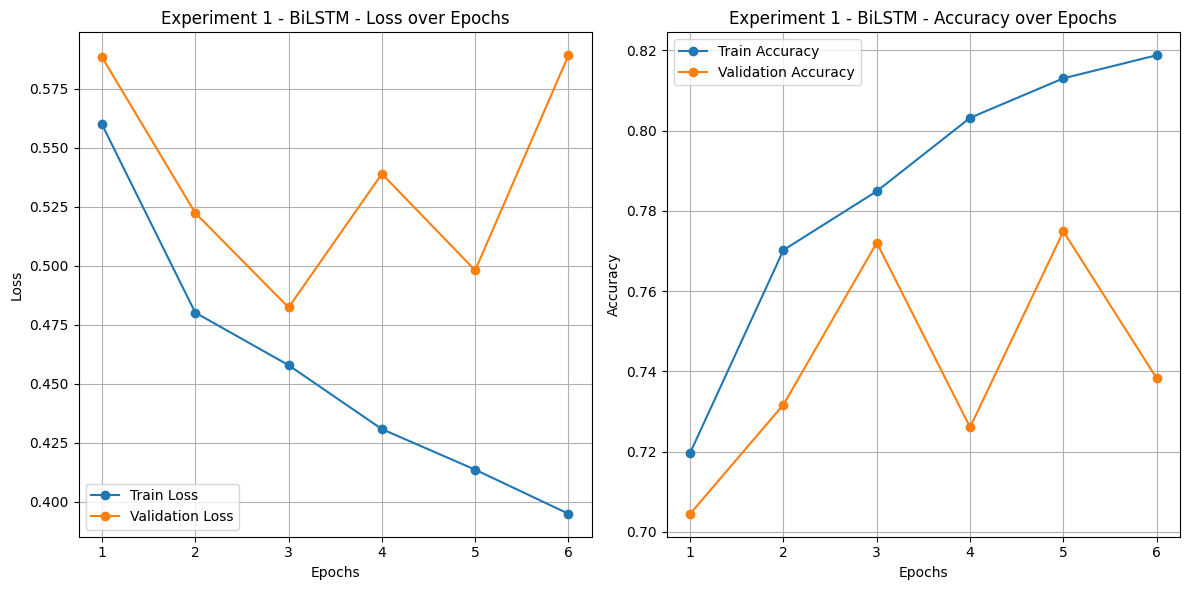


Training BiGRU model:
Epoch [1/50]
Train Loss: 0.5666, Train Acc: 0.7186
Val Loss: 0.5479, Val Acc: 0.7326
Epoch [2/50]
Train Loss: 0.4832, Train Acc: 0.7678
Val Loss: 0.5549, Val Acc: 0.7242
Epoch [3/50]
Train Loss: 0.4565, Train Acc: 0.7790
Val Loss: 0.5250, Val Acc: 0.7430
Epoch [4/50]
Train Loss: 0.4391, Train Acc: 0.7986
Val Loss: 0.5109, Val Acc: 0.7514
Epoch [5/50]
Train Loss: 0.4186, Train Acc: 0.8055
Val Loss: 0.5036, Val Acc: 0.7711
Epoch [6/50]
Train Loss: 0.3981, Train Acc: 0.8190
Val Loss: 0.5192, Val Acc: 0.7674
Epoch [7/50]
Train Loss: 0.3835, Train Acc: 0.8266
Val Loss: 0.4886, Val Acc: 0.7739
Epoch [8/50]
Train Loss: 0.3605, Train Acc: 0.8402
Val Loss: 0.5059, Val Acc: 0.7739
Epoch [9/50]
Train Loss: 0.3442, Train Acc: 0.8485
Val Loss: 0.5273, Val Acc: 0.7655
Epoch [10/50]
Train Loss: 0.3088, Train Acc: 0.8630
Val Loss: 0.5972, Val Acc: 0.7655
Early stopping as validation accuracy is not improving


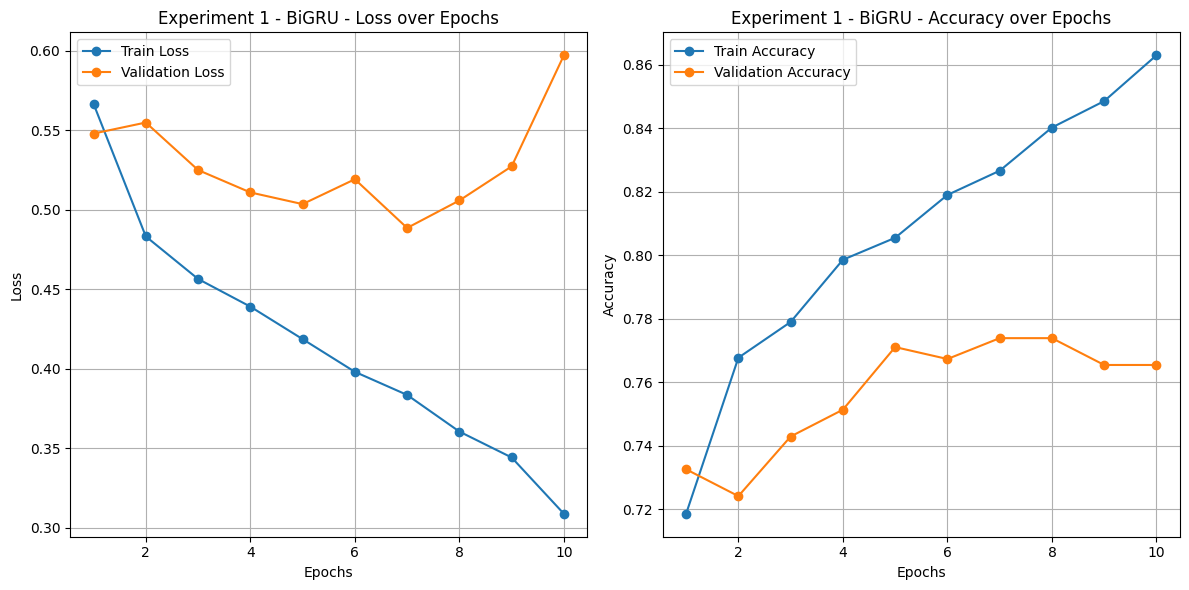

In [79]:
# Run the training
if __name__ == "__main__":
    train_both_models()

In [80]:
# Test set evaluation
def evaluate_test_set(model_name, model, test_loader, criterion):
    print(f"\nEvaluating {model_name} on test set:")
    model.load_state_dict(torch.load(f'Final - P3_Q3 - Word2Vec - {model_name.lower()}.pth'))
    model.to(device)
    model.eval()

    test_loss, test_acc = evaluate_epoch(model, test_loader, criterion)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    return test_loss, test_acc

In [82]:
# Evaluate on test set
#'BiLSTM' & 'BiGRU'
# First make sure we have the test data loader
test_loader = DataLoader(test_data, batch_size=32)

# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Initialize the models
with open(f"{os.getcwd()}/best_config.json", "r") as file:
    best_params = json.load(file)
pooling = best_params["pooling"]

bilstm_model = BiLSTMModel(
    embedding_matrix,
    hidden_dim=256,
    output_dim=2,
    pooling=pooling,
    n_layers=2,
    dropout_rate=0.5,
)
bigru_model = BiGRUModel(
    embedding_matrix,
    hidden_dim=256,
    output_dim=2,
    pooling=pooling,
    n_layers=2,
    dropout_rate=0.5,
)

# Evaluate BiLSTM
evaluate_test_set("BiLSTM", bilstm_model, test_loader, criterion)

# Evaluate BiGRU
evaluate_test_set("BiGRU", bigru_model, test_loader, criterion)


Evaluating BiLSTM on test set:


/var/folders/0f/9lfqv2_d3dd8rwwcwl7x4r000000gr/T/ipykernel_22658/1239609556.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'Final - P3

Test Loss: 0.4860, Test Acc: 0.7720

Evaluating BiGRU on test set:
Test Loss: 0.5011, Test Acc: 0.7655


(0.5011294387719211, 0.7654784240150094)